# Predicting Fantasy Football Points

If you read my last [post](http://nbviewer.ipython.org/github/tfolkman/learningwithdata/blob/master/Biggest_Misses.ipynb) you will know that I recently started fantasy football and my team isn't doing so great. Currently 0 and 4. Ha!

What seemed strange to me, though, is that my team kept underperforming relative to the ESPN projections. The consistent underperformance lead me to try and develop my own prediction model to see if I couldn't maybe do a better job.

Skip the next few blocks of code to see more discussion.

In [1]:
import sqlalchemy
from sqlalchemy.orm import create_session
from sklearn import preprocessing
from collections import namedtuple
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='Set2')
%matplotlib inline

In [2]:
engine = sqlalchemy.create_engine('postgresql://localhost/fantasyfootball')    
session = create_session(bind=engine)

In [3]:
class Prediction:

    
    def __init__(self, test_proj_week, position='ALL'):
        self.train_proj_week = test_proj_week - 1
        self.test_proj_week = test_proj_week
        self.position = position


    def make_prediction(self):
        encoders = self.create_position_factors()
        
        self.train_data = self.week_df(self.train_proj_week, encoders.position,
                             encoders.team, self.position)
        test_data = self.week_df(self.test_proj_week, encoders.position, encoders.team, self.position)
        
        clf = RandomForestRegressor(n_estimators=5000, max_depth=5)
        clf.fit(self.train_data.X, self.train_data.y)
        model_predicted_points = clf.predict(test_data.X)
        
        results = self.rmean_sq(test_data.y.values, model_predicted_points)
        espn = self.rmean_sq(test_data.y.values, test_data.espn_proj.values)
        
        # Put some variables in self for easier access
        self.my_prediction = model_predicted_points
        self.model = clf
        self.results = results
        self.espn_results = espn
        self.actual = test_data.y.values
        self.espn_prediction = test_data.espn_proj.values
        
        self.get_combined_df(test_data)
      
    
    def get_combined_df(self, data):
        df=pd.concat([data.X, data.index, data.espn_proj, data.y], axis=1)
        df['name'] = df['index'].str.split("_").str.get(0)
        df['team'] = df['index'].str.split("_").str.get(1)
        df['position'] = df['index'].str.split("_").str.get(2)
        df['my_prediction'] = self.my_prediction
        self.combined_test_df = df
        
    
    def report(self):
        print("Prediction for Week {0} for {1} position(s)".format(self.test_proj_week, self.position))
        print("My RMSE: {}".format(self.results.rmse))
        print("ESPN RMSE: {}".format(self.espn_results.rmse))
        self.plot_feature_importance()
        plt.title("Feature Importance", fontsize=20)
        plt.show()
        self.plot_dist_comp()
        plt.title("Distribution of RMSE", fontsize=20)
        plt.show()
        self.scatter_plot(self.actual, self.my_prediction)
        plt.title("My Predictions", fontsize=20)
        plt.show()
        self.scatter_plot(self.actual, self.espn_prediction)
        plt.title("ESPN Predictions", fontsize=20)
        plt.show()
        
    
    def plot_feature_importance(self):
        plt.figure(figsize=(8,5))
        df = pd.DataFrame()
        df['fi'] = self.model.feature_importances_
        df['name'] = self.train_data.X.columns
        df = df.sort('fi')
        sns.barplot(x=df.name, y=df.fi)
        plt.xticks(rotation='vertical')
        sns.despine()
        
    
    def plot_dist_comp(self):
        plt.figure(figsize=(8,5))
        sns.distplot(self.results.array, label="Me")
        sns.distplot(self.espn_results.array, label="ESPN")
        plt.legend()
        sns.despine()
        
    
    def scatter_plot(self, x, y):
        plt.figure(figsize=(8,5))
        max_v = 40
        x_45 = np.arange(0, max_v)
        plt.scatter(x, y)
        plt.plot(x_45, x_45)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.ylim([0, max_v])
        plt.xlim([0, max_v])
    
    
    def week_df(self, proj_week, position_encoder, team_encoder, position = 'ALL'):
        
        # Get actual data for all previous weeks
        actual_data = pd.read_sql_query("""select name, team, position, opponent, week,
                                    at_home, total_points, won_game, opponent_score, team_score
                                    from scoring_leaders_weekly""", engine)
        
        # Calculate how team's perform on average against positions for fantasy points
        team_data = pd.DataFrame(actual_data.groupby(['opponent', 'position']).total_points.mean())
        team_data.reset_index(level=0, inplace=True)
        team_data.reset_index(level=0, inplace=True)
        team_data.rename(columns={'total_points': 'opponent_points'}, inplace=True)
        actual_data = actual_data.merge(team_data, on=['opponent', 'position'], how='left')
        team_data.rename(columns={'opponent_points': 'next_opponent_points', 'opponent': 'next_opponent'}, inplace=True)
        
        actual_data['index'] = actual_data.name + "_" + actual_data.team + "_" + actual_data.position
        actual_data.week = actual_data.week.astype(int)
        actual_data = actual_data[actual_data.week < proj_week]

        # Calculate the average values for previous week metrics
        wgt_df = actual_data[['opponent_points', 'index', 'at_home', 'total_points',
                              'won_game', 'opponent_score', 'team_score']]
        group_wgt_df = wgt_df.groupby('index')
        player_df = group_wgt_df.mean()
        player_df.reset_index(level=0, inplace=True)
        
        # Get the opponent data for the next week as well as espn projection
        predicted_data = pd.read_sql_query("""select name, team, position, opponent as next_opponent,
                                            at_home as next_at_home, total_points as predicted_points
                                            from next_week_projections
                                            where week = '{0}'""".format(proj_week), engine)
        predicted_data['index'] = predicted_data.name + "_" + predicted_data.team + "_" + predicted_data.position
        predicted_data.drop(['name', 'team'], axis=1, inplace=True)

        # Start combining everything - messy - sorry...
        X = player_df.merge(predicted_data, on='index', how='left')
        X = X.dropna()

        # Get the actual result as our target
        actual_result = pd.read_sql_query("""select name, team, position, total_points as actual_points
                                            from scoring_leaders_weekly
                                            where week = '{0}'""".format(proj_week), engine)
        actual_result['index'] = actual_result.name + "_" + actual_result.team + "_" + actual_result.position
        actual_result.drop(['name', 'team', 'position'], axis=1, inplace=True)

        X = X.merge(actual_result, on='index', how='left')
        X = X.merge(team_data, on=['position', 'next_opponent'], how='left')
        X = X.dropna()
        if position != 'ALL':
            X = X[X.position == position]
        y = X.actual_points

        X['team'] = X['index'].str.split("_").str.get(1)

        # Sklearn won't create factors for you, so encode the categories to integers
        X['team_factor'] = team_encoder.transform(X.team)
        if position == 'ALL':
            X['position_factor'] = position_encoder.transform(X.position)
        X['next_opponent_factor'] = team_encoder.transform(X.next_opponent)

        espn = X['predicted_points']
        index = X['index']
        X.drop(['predicted_points', 'actual_points', 'team', 'position', 'next_opponent', 'index'], axis=1, inplace=True)
        
        # Return named tuple of all the data I need
        week_tuple = namedtuple('Week', ['X', 'y', 'espn_proj', 'index'])
        return week_tuple(X, y, espn, index)
    
    
    def create_position_factors(self):
        # Convert positions into integer categories
        position_encoder = preprocessing.LabelEncoder()
        positions = np.ravel(pd.read_sql_query("""select distinct position from scoring_leaders_weekly;""", engine).values)
        position_encoder.fit(positions)

        # Convert team names into integer categories
        team_encoder = preprocessing.LabelEncoder()
        teams = np.ravel(pd.read_sql_query("""select distinct team from scoring_leaders_weekly;""", engine).values)
        team_encoder.fit(teams)
        encoders = namedtuple('encoders', ['team', 'position'])
        return encoders(team_encoder, position_encoder)
    
    
    def rmean_sq(self, y_true, y_pred):
        rmse = namedtuple('rmse', ['rmse', 'array'])
        sq_error = []
        assert len(y_true) == len(y_pred)
        for i in range(len(y_true)):
            sq_error.append((y_true[i] - y_pred[i])**2)
        return rmse(np.sqrt(np.mean(sq_error)), np.sqrt(sq_error))

# Put my model to the test

If you look through the class above, you will see that I am using a random forest regressor as my model of choice with 5,000 trees and a max depth of 5. I did some cross validation testing with a few other models and hyper parameter selection and this seemed to work the best.

I use a handful of variables including things like a player's average fantasy points, the average number of game's a player has won, and a player's position (more on variables in a bit). I tried modeling each position individually, but a global model provided a better root mean squared error in the end.

So - lets try it out. What I will be doing is predicting fantasy points for players in week 3 of the season. To do this, I will use week 2 as my training set. Thus, I use week 1 data to train my model to predict week 2 outcomes. I then take this trained model and use it with week 1 and 2 data to predict week 3 fantasy points for players. Here we go...

Prediction for Week 3 for ALL position(s)
My RMSE: 6.56041003517
ESPN RMSE: 6.76700270293


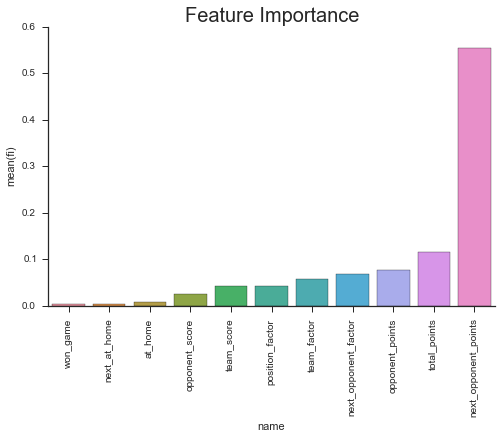

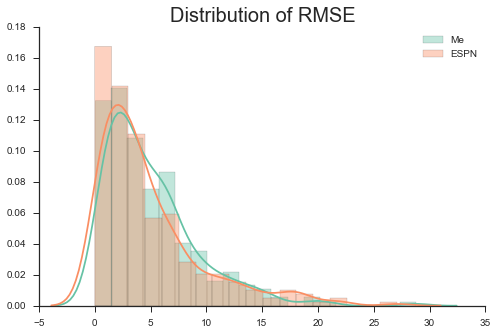

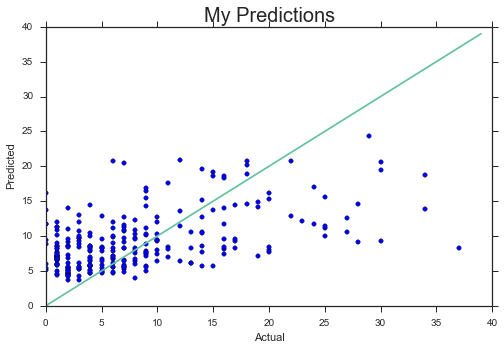

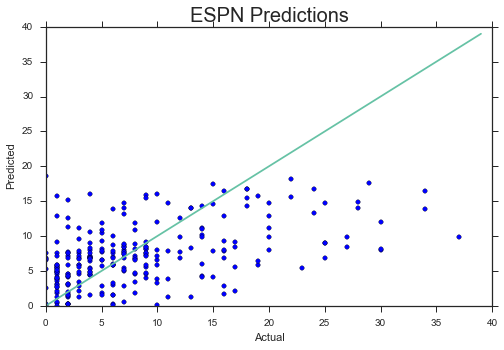

In [4]:
week_3_proj_all = Prediction(3)
week_3_proj_all.make_prediction()
week_3_proj_all.report()

# Analysis

## RMSE 

First, you will notice that I achieved a better RMSE than ESPN! Yay! The next thing you should notice is that I barely did better. But RMSE is just a single number, so lets dive a bit deeper.

## RMSE Distribution

Looking at the second graph you will see both distributions of RMSE. ESPN is doing a better job of getting more of their prediction errors close to zero. While my model has less area in the tail, so doesn't have as many big prediction errors as ESPN does. I also have more prediction errors in the 5-10 value range. These results can also be seen in the scatter plots. ESPN's predictions don't perform very well with very high actual fantasy point values. My model also suffers from this problem. This seems to make sense; these are most likely big games for these players with above average results that would be hard to predict with any confidence. My big win seems to be for players performing in the 5-15 point range. My model handles these better than ESPN with less low predictions in this range. Both models also have a lot of errors when players have low actual values. My model tends to over predict these, while ESPN has over and under predictions. These are probably players with bad games, so my model based on past, better performance is over shoting. ESPN probably has some better domain knowledge that can sometimes lead to over predicting a bad performance. 

## Feature Importance

I found these results to be very fascinating. You will immediately notice that **next_opponent_points** is very important in my model. This variable is the average fantasy points that the opponent team the player will be against in week 3 has allowed for the player's position in the previous weeks for the season. I think this is sometimes called points against and it is very important. This is something I really overlooked in my drafting. I didn't really consider a player's schedule at all. These results suggest that analyzing a player's schedule can be extremely important. A great running back could have some bad fantasy games if up against some good run defenses.

The next variable, **total_points** is the player's average fantasy points thus far in the season. **Opponent_points** is like **next_opponent_points** but it is the average value for that player's team for all the teams he has played thus far in the season. **Next_opponent_factor** is just the actual team the player will be playing in week 3. **Team_factor** is the player's team. **Team_score** is the average score for the player's team for past games. **Position_factor** is the player's position. **Opponent_score** is the same as **team_score** but for the player's opponents. **At_home** is average number of games at home. **Next_at_home** is whether next game is at home. **Won_game** is average number of games won in the past.

In [5]:
data = week_3_proj_all.combined_test_df
data['my_error'] = np.sqrt((data['my_prediction'] - data['actual_points'])**2)
data['espn_error'] = np.sqrt((data['predicted_points'] - data['actual_points'])**2)
data = data[['position', 'my_error', 'espn_error']]
data = pd.melt(data, id_vars=['position'], value_vars=['my_error', 'espn_error'])
data.columns = ['position', 'type', 'error']

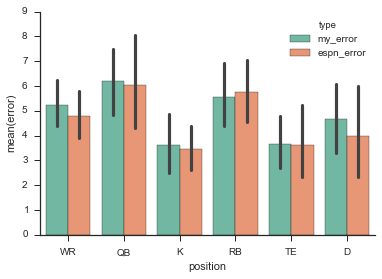

In [6]:
sns.barplot(x='position', y='error', hue='type', data=data)
sns.despine()

# Results by Position

The above bar chart shows how the models do by position. There are not too many surprises here. Less volatile positions like K and TE have lower average errors while positions like QB and RB have higher average errors. ESPN beats me across the board on average except for RB (but all values are close). One sort of interesting point is that my model has a noteable smaller standard deviation for QBs. But again, all differences are slight.

# Conclusion

Predicting fantasy points is hard. On average the models are only off by about 6.5 points, but can miss pretty big when players do very well or poorly, which is really what you usually care about. This is inheritely a challenging problem - how do you use past data to try and determine a future performance that differs from that past (like a break out game or a slump)? On some level, I imagine this is impossible, but think we could maybe do better. For instance, my model doesn't account for injury at all. Knowing that a player is coming off an injury could be very valuable. Or knowing that a key offensive lineman is out could really affect a RBs performance. I think the NFL has a lot of cool work that could be done with the right data and some deep thought about how these data could be used to understand performance.

Second, I was very happy to gain some more insight into what variables seem to matter when trying to predict a player's fantasy points. In the future, I will be paying a lot more attention to a player's opponents.

Lastly, I think it is really cool that with only a handful of variables a model could be developed that performs very similar to ESPN's prediction model. This is what I **love** about data science. I was able to use data to gain a much deeper undertanding of an area in which I am far from an expert. I have no idea how ESPN creates their predictions, but I imagine they put some effort into it, and I think it is awesome that with just my laptop and some data I could create a competing model. If anyone from ESPN is reading this...I'd love to connect and learn some more about your model :). 

P.S. - I will try and post some updates on the performance of the models as the season progresses if anyone is interested.